# LDA Topic Modelling

Latent Dirichlet Allocation (LDA) is a powerful and widely used statistical topic modelling technique. It is used to uncover the hidden topics in a collection of documents, by uncovering the latent topics that occur in the documents. LDA is a generative probabilistic model that assumes each topic is a mixture over an underlying set of words and each document is a mixture of over a set of topics. LDA is unsupervised in nature, thus it requires no labeled data and can uncover the topics in any given collection of documents. It is a powerful tool for discovering abstract topics from a large collection of documents, and has been found to be highly effective in many applications.

In [ ]:
!pip install gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import json
import string
from pathlib import Path
from typing import Union
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from tqdm import notebook
from bs4 import BeautifulSoup
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#gensim librairies
import gensim
from gensim import corpora
from pprint import pprint

### Data

In [ ]:
#Connection with my drive folder
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
directory = 'drive/MyDrive/Colab_Notebooks/fulltext'

data = dict()

file_list = os.listdir(directory)

for filename in notebook.tqdm(file_list):
    with open(directory + "/" + filename, 'r') as f:
        raw_data = f.read()
    
    bs_data = BeautifulSoup(raw_data,'xml')
    
    texts = list()
    
    if bs_data.findChild('sentences') == None:
        # If there are no sentences, extract the text from each <text> tag
        for tag in bs_data.find_all('text'):
            texts.append(tag)
    else:
        # If there are sentences, extract the text from each <sentences> tag
        for tag in bs_data.find_all('sentences'):
            texts.append(tag)
  
  data[filename] = texts

  0%|          | 0/3890 [00:00<?, ?it/s]

In [ ]:
def clean_data(doc:str) -> str:
    x = re.sub(r'\n', '', doc) #we remove \n
    x = re.sub(r"\'", '', x)
    return x

In [ ]:
documents = [clean_data(data[key][0].text) for key in data.keys()]

### LDA

In [ ]:
commons_words = ["mr", "ms"]

After several experiments, we came to the conclusion that the optimal number of clusters was 3.

In [ ]:
# Tokenize words and remove stop words
stopwords = gensim.parsing.preprocessing.STOPWORDS

texts = [[word for word in document.lower().split() if (word not in stopwords) or (word not in commons_words)] for document in documents]

# Create a dictionary from the documents
dictionary = corpora.Dictionary(texts)

# Create a corpus from the documents
corpus = [dictionary.doc2bow(text) for text in texts]

# Train LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=dictionary,
                                            num_topics=3, 
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

In [ ]:
results = list()
docs = list()
for i, doc in enumerate(corpus):
    for topic, prob in lda_model.get_document_topics(doc, minimum_probability=0.5):
        results.append(topic+1)
        docs.append([" ".join(texts[i]), topic+1])

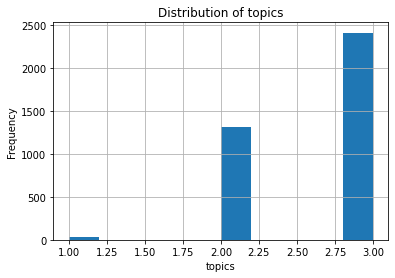

In [ ]:
pd.DataFrame(results).hist()

plt.title("Distribution of topics")
plt.xlabel("topics")
plt.ylabel("Frequency")
plt.show()

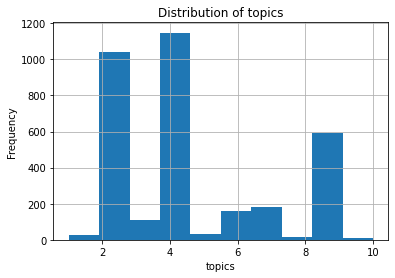

In [ ]:
#@title Sanity check
pd.DataFrame(results).hist()

plt.title("Distribution of topics")
plt.xlabel("topics")
plt.ylabel("Frequency")
plt.show()

We explored a little more clusters but 3 seems to be the optimum. Here are the paramaters we used for this result:
- num_topics=10
- random_state=100
- update_every=1
- chunksize=2000
- passes=20
- alpha='auto'
- eta=''auto
- per_word_topics=True



### Top words for each cluster

In [ ]:
df_doc = pd.DataFrame(docs)
df_doc

,0,1
0,1 this appeal raises two issues on both of whi...,2
1,1 this is a matter which is listed for judgmen...,2
2,"1 on 18 april 2008 the plaintiff (""nationwide""...",3
3,1 on 29 february 2008 an application for an or...,3
4,1 this is an appeal from an order made by a fe...,2
...,...,...
3753,1 the applicant is the registered proprietor o...,3
3754,1 this is an application for an extension of t...,2
3755,1 there are two notices of motion before me to...,3
3756,introduction 1 marilyn mee ching pelka was in ...,2


In [ ]:
def extract_top_words(documents):
    # Create a TF-IDF vectorizer
    vectorizer = TfidfVectorizer(stop_words='english')
    # Fit and transform the documents
    tfidf_matrix = vectorizer.fit_transform(documents)
    # Get the feature names (i.e. words)
    feature_names = vectorizer.get_feature_names()
    # Get the TF-IDF scores for each word in each document
    tfidf_scores = tfidf_matrix.toarray()
    # Compute the mean TF-IDF score for each word across all documents
    mean_tfidf_scores = tfidf_scores.mean(axis=0)
    # Sort the words by their mean TF-IDF score
    top_words_indices = mean_tfidf_scores.argsort()[::-1][:20]
    top_words = [feature_names[i] for i in top_words_indices]
    return top_words

TF-IDF stands for "term frequency-inverse document frequency". It is a numerical statistic that is commonly used in natural language processing and information retrieval to evaluate the importance of a word in a document.

In [ ]:
def stem(tokens: list) -> list:
  """
  Stems the tokens using Porter stemmer.
  """
  stemmer = PorterStemmer()
  return [stemmer.stem(token) for token in tokens]


def remove_short_tokens(tokens: list) -> list:
    """
    Removes tokens with length <= 2.
    """
    return [token for token in tokens if len(token) > 2]

In [ ]:
def get_frequency_of_words(texts: list, filter_list: list) -> pd.DataFrame:
    """
    Returns the frequency of words in a list of texts that are present in a filter list.

    Args:
    - texts (list): A list of strings to process.
    - filter_list (list): A list of words to filter by.

    Returns:
    - A pandas DataFrame with two columns: 'words' and 'count', sorted by count in descending order.
    """

    # Create a CountVectorizer object with the desired n-gram range and stop words
    vectorizer = CountVectorizer(vocabulary=filter_list)
    # Fit and transform the input texts
    X = vectorizer.fit_transform(texts)

    # Get the word names and their counts
    words = vectorizer.get_feature_names()
    counts = X.toarray().sum(axis=0)

    res = [[count, word] for word, count in zip(words, counts) if count > 0]

    res.sort(reverse=True)

    df_count = pd.DataFrame(res, columns=['count', 'words'])
    return df_count

In [ ]:
res = dict()
for i in df_doc[1].unique():
  cluster_doc = df_doc[0][df_doc[1]==i].values
  print("------------ top words based on TF-IDF for cluster "+ str(i) +"-------------")
  top_words = extract_top_words(cluster_doc)
  res[i] = list(dict.fromkeys(remove_short_tokens(top_words)))
  print(f"Top words for cluster {i}: {', '.join(top_words)}")

------------ top words based on TF-IDF for cluster 2-------------
Top words for cluster 2: tribunal, appellant, applicant, decision, court, application, appeal, federal, appellants, act, evidence, minister, review, magistrate, did, hearing, information, 2006, visa, mr
------------ top words based on TF-IDF for cluster 3-------------
Top words for cluster 3: mr, court, act, applicant, respondent, respondents, costs, order, applicants, application, evidence, claim, 2006, 2007, 2008, case, proceedings, 2009, company, orders
------------ top words based on TF-IDF for cluster 1-------------
Top words for cluster 1: native, area, title, scheme, determination, act, rights, interests, land, yawuru, claim, people, traditional, waters, court, aboriginal, group, application, lease, areas


In [ ]:
#@title Top words by keywords after removing common words between clusters
print("-----------------------------------------------------------------------------------------------")
print(f"Top words for cluster {1}: {', '.join(list(set(res[1]) - set(res[2]) - set(res[3])))}")
print(get_frequency_of_words(df_doc[0][df_doc[1]==i].values, list(set(res[1]) - set(res[2]) - set(res[3]))))
print("-----------------------------------------------------------------------------------------------")
print(f"Top words for cluster {2}: {', '.join(list(set(res[2]) - set(res[1]) - set(res[3])))}")
print(get_frequency_of_words(df_doc[0][df_doc[1]==2].values, list(set(res[2]) - set(res[1]) - set(res[3]))))
print("-----------------------------------------------------------------------------------------------")
print(f"Top words for cluster {3}: {', '.join(list(set(res[3]) - set(res[1]) - set(res[2])))}")
print(get_frequency_of_words(df_doc[0][df_doc[1]==3].values, list(set(res[3]) - set(res[1]) - set(res[2]))))

-----------------------------------------------------------------------------------------------
Top words for cluster 1: lease, land, rights, determination, yawuru, waters, area, aboriginal, interests, people, title, native, group, scheme, traditional, areas


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


    count          words
0    4164         scheme
1    1316          title
2    1301           area
3    1288         native
4    1057  determination
5     953         rights
6     830         yawuru
7     818      interests
8     777           land
9     677          group
10    547    traditional
11    543         people
12    499          lease
13    376         waters
14    299          areas
15    284     aboriginal
-----------------------------------------------------------------------------------------------
Top words for cluster 2: appellants, review, hearing, did, appeal, decision, appellant, magistrate, tribunal, federal, visa, information, minister


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


    count        words
0   50903     tribunal
1   26669    appellant
2   26386     decision
3   14616       appeal
4   12865          did
5   12705      federal
6   12346     minister
7   11539       review
8   10944   appellants
9   10903      hearing
10   9683         visa
11   9043  information
12   7313   magistrate
-----------------------------------------------------------------------------------------------
Top words for cluster 3: order, 2009, company, orders, 2008, costs, respondent, applicants, proceedings, 2007, case, respondents
    count        words
0   29400   respondent
1   29387         case
2   28518        order
3   23582  respondents
4   23565   applicants
5   21725        costs
6   19489      company
7   18543  proceedings
8   18059         2007
9   14688       orders
10  13872         2008
11   8932         2009


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


The data presented pertains to cases handled by the Australian Federal Court, which is the highest court in the Australian federal judiciary system. As in many federal countries, Australia has courts at various levels, such as local, state, and federal civil courts. The Federal Court is therefore the final court of appeal for parties dissatisfied with decisions made by lower courts.

The first cluster of data groups together decisions made by lower courts. The terms used, such as "rights," "yawuru," "native", "area" might refer to civil cases.

The second cluster of data groups together appeal decisions. The terms used, such as "appeal," "tribunal," "decision," and "federal," indicate that these are parties dissatisfied with decisions made by lower courts and who have appealed to the Federal Court.

Finally, the third cluster of data groups together decisions made by the Federal Court. The terms used, such as "order" and "cost," indicate that these are final decisions and associated costs, as presented on the official website of the Australian Federal Court.

**If we had more time**:

It would be interesting to integrate the result of NER (named entity recognition) to perform LDA (directed hierarchical classification model). For example, replacing all MISC entities with the word MISC would reduce noise and group the data under one term. While this is not something that can be tested quickly, it is worth discussing.